# What happened earlier ...
1. The features and the label were selected
1. The features were scaled (by standardizing them to a mean of 0 and std. deviation of 1)
1. Some of the data was used to test the selected classification model (linear regression)
1. After the training was done, the model was tested by applying it on the rest of the data
1. The predicted values were saved into the dataframe and visualized

## New
### Pickling saves time by using the pre-trained classifier without the need to retrain it 
1. Serialization: saving the classifier once it is trained
1. Deserialization: loads the classifier back in to use it 

Pickling is used for two main purposes:

**Saving Trained Models**: After spending resources and time to train a machine learning model, you can save it to a file (pickling) so that you can easily load it back later. This is particularly useful for making predictions on new data without retraining the model.

**Sharing Models**: Pickling allows you to share your trained model with others or deploy it to different environments, such as moving it from a development environment to a production server.

### Scaling in the context of computing resources is defined as using the power of Online web servers to train a model fast and more efficiently
1. load data and code up to a web server like AWS
1. rent the web server power to train your model
1. save the trained model to a pickle file
1. download the model and use it further

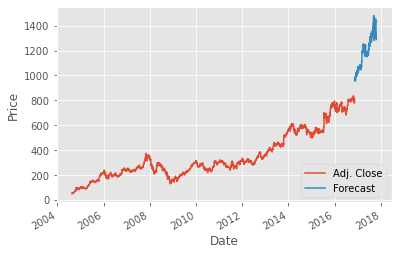

In [3]:
import pandas as pd
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, svm, model_selection
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

style.use('ggplot')

df = quandl.get('WIKI/GOOGL')
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)

forecast_out = int(math.ceil(0.1*len(df)))
#print(forecast_out)

df.tail()

df['label'] = df[forecast_col].shift(-forecast_out)
df.head()

X = np.array(df.drop(['label'],axis=1))
X = preprocessing.scale(X)

X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)
y = np.array(df['label'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

clf = LinearRegression()
clf.fit(X_train, y_train)

# opens a file and writes (in binary mode, thus serialization) the classifier into the file named f
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)

# Deserialization: the classifier is loaded back into memory to use it (rb = read binary)
pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

accuracy = clf.score(X_test, y_test)

forecast_set = clf.predict(X_lately)
# print(forecast_set, accuracy, forecast_out)

df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()